In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

%config InlineBackend.figure_format = 'retina'

In [2]:
# Object Details

#=============================================================================
# Details of the object under study
# =============================================================================

Object = 'SN2011aa'       
Redshift = 0.013                # From https://www.wis-tns.org/object/2020sck
EB_V_Gal = 0.065                # Only considering the Galaxy component  https://ned.ipac.caltech.edu/
EB_V_err_Gal = 0.004             # Schlafly & Finkbeiner 2011.
EB_V_Host = 0.00                # No Na-I D lines in HCT spectra observed at the redshift of the host galaxy.
EB_V_err_Host = 0.00
JD_offset = 2459000
epoch = 2400000.5
RA = '07:36:42.63'              # https://www.wis-tns.org/object/2011aa
DEC = '+74:26:34.80'
Rv_MW = 3.1                     # The value of total-to-selective absorption
Rv_HG = 3.1
B_max = 2455611.65              # Calculated from spline, MLCS2k2 and SNooPy(E(B-V) model) 
DM = 33.75                      # http://leda.univ-lyon1.fr/ledacat.cgi?o=2MASX%20J01103497%2B0206508%20
DM_err = 0.27                   # 
dm15 = 0.59                     # Calculated from GP-fit
dm15_err = 0.01
z = 0.013

In [15]:
obs_spec_files = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/'
model1_spec_files = '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/'
model2_spec_files = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/'

In [27]:
# Functions for File handling

def remove_file(file_name):
    """
    Removes the file 'file_name' in the constituent directory.
    Args:
         file_name  : Name of the file to be removed from the current directory
    Returns:
        None
    """
    try:
        os.remove(file_name)
    except OSError:
        pass
    
#-------------------------------------------------------------------------------#

def remove_similar_files(common_text):
    """
    Removes similar files based on the string 'common_text'.
    Args:
        common_text : String containing partial name of the files to be deleted
    Returns:
        None
    """
    for residual_file in glob.glob(common_text):
        remove_file(residual_file)
        
#-------------------------------------------------------------------------------#

def group_similar_files(text_list, common_text, exceptions=''):
    """
    Groups similar files based on the string 'common_text'. Writes the similar files
    onto the list 'text_list' (only if this string is not empty) and appends the similar
    files to a list 'python_list'.
    Args:
        text_list   : Name of the output text file with names grouped based on the 'common_text'
        common_text : String containing partial name of the files to be grouped
        exceptions  : String containing the partial name of the files that need to be excluded
    Returns:
        list_files  : Python list containing the names of the grouped files
    """
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exception = exceptions.split(',')
        for file_name in glob.glob(common_text):
            for text in list_exception:
                test = re.search(text, file_name)
                if test:
                    try:
                        list_files.remove(file_name)
                    except ValueError:
                        pass

    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name + '\n')

    return list_files

#-------------------------------------------------------------------------------#

def cal_dist(dist_mod, dist_mod_err):
    
    '''
    Calculates distance and distance error
    
    dist_mod: Distance Modulus.
    dist_mod_err: Distance Modulus Error.
    
    '''
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_mod_err)/5
    
    return [d, d_err]

#-------------------------------------------------------------------------------#

def flux_to_lum(flux):
    
    '''
    Calculate luminosity from flux value
    
    flux: flux value to be converted to luminosity.
    
    '''
    
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*cal_dist(DM, DM_err)[0]**2
    
    return luminosity

#-------------------------------------------------------------------------------#

def ejecta_mass(velocity_list, density_list):
    
    t_exp_sec = t_exp * 86400     # in secs
    const_Mej = (4*np.pi)/3
    M_ej = 0.0 
    for i in range(len(velocity_list)):
        if i < len(velocity_list)-1:
            M_ej += const_Mej * density_list[i] * (velocity_list[i]*t_exp_sec)**3
            
    M_sun = 1.989e33              # g
    norm_Mej = M_ej/M_sun         # in terms of solar mass
    #print (norm_Mej)
            
    return M_ej, norm_Mej



def plot_spectrum(spectrum_text_file, ax, ml_x, mil_x, ml_y, mil_y, phase):
    
    clip_str = '3500:9100'
    plt.rcParams['axes.linewidth']=3
    #fig = plt.figure(figsize = (6,6))
    #ax = fig.add_subplot(111)
    lower_limit, upper_limit = clip_str.split(':')

    data_df = pd.read_csv(spectrum_text_file, names = ['Wavelength', 'Flux'], sep = '\s+', dtype = 'float64')
    data_df = data_df[(data_df['Wavelength'] >= int(lower_limit)) & (data_df['Wavelength'] <= int(upper_limit))]
    data_df['Lum'] = data_df['Flux'].apply(lambda x: flux_to_lum(x))
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 3.0, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.5, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 20)
                #tick.label1.set_fontweight('bold')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 20)

    ax.plot(data_df['Wavelength'], data_df['Lum'], label = phase, alpha = 1.0, 
           lw=2.0, color='#03071e')
    ax.legend(fontsize=30, frameon=False, borderaxespad=2.0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#-------------------------------------------------------------------------------#    
    
def plot_tardis_model(spectrum_text_file, tardis_spectrum, scale, ml_x, mil_x, ml_y, mil_y):
    
    fig = plt.figure(figsize=(12,8))
    #fig, ax = plt.subplots(2, 1, figsize=(15,20), sharex=True, gridspec_kw={'height_ratios':[2, 1]})
    #fig.subplots_adjust(hspace=0.01, wspace=0.1)

    plt.rcParams['axes.linewidth']=3
    ax = fig.add_subplot(111)

    clip_str = '3100:9100'
    lower_limit, upper_limit = clip_str.split(':')
    
    columns = ['Wavelength', 'Flux']
    data_df = pd.read_csv(spectrum_text_file, sep = '\s+', dtype = 'float64', names=columns)
    data_df = data_df[(data_df['Wavelength'] >= int(lower_limit)) & (data_df['Wavelength'] <= int(upper_limit))]
    data_df['Lum'] = data_df['Flux'].apply(lambda x: flux_to_lum(x))
    
    ax.xaxis.set_ticks_position('default')
    ax.yaxis.set_ticks_position('default')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 3.0, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.5, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 40)
                #tick.label1.set_fontweight('bold')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = 40)
        
    ax.plot(data_df['Wavelength'], data_df['Lum'], label = '_nolegend_', alpha = 1.0, lw=2.0, color='red')
    ax.plot(tardis_spectrum.wavelength, tardis_spectrum.luminosity_density_lambda*scale, 
            label='formal integral', ls='--', color='black', lw=2.0)
    
    ax.legend(fontsize=15, borderaxespad=3.0)

    ax.set_xlabel('Wavelength [$\AA$]', fontsize=25)
    ax.set_ylabel('Luminosity [erg/s/$\AA$]', fontsize=25)
    
    
    #ax.set_yscale("log")
    
    #print (len(data_df['Wavelength']))
    #print (len(tardis_spectrum.wavelength))
    
    #tardis_residual = data_df['Lum'] - tardis_spectrum.luminosity_density_lambda.value 
    
    #ax[1].plot(data_df['Wavelength'], tardis_residual)
    
#-------------------------------------------------------------------------------#   

def plot_sedona_spectrum(filename, ax, label, scale=1.0, color='black'):
    
    df = pd.read_csv(filename, sep='\s+', engine='python')
    ax.plot(df['Wavelength'], df['L_lambda'] * scale, color=color, alpha=0.8, lw=3.0, label=label)
    ax.legend(fontsize=30, frameon=False, borderaxespad=2.0)
    
def open_yaml(yaml_file):
    
    with open(tardis_yaml_file) as yaml_file:
        tardis_config = yaml.load(yaml_file, Loader=yaml.FullLoader)
        
        #for items, value in tardis_config.items():
        #    print (items, ':', value)
        
    return tardis_config


def homologous_expansion(rho_ref, t_ref, t_exp):
        
        '''
        rho_ref : rho(v) at time explosion time t0.
        t_ref: reference explosion epoch in days.
        t_exp: time since explosion when density is being calculated in days.
        
        returns: rho
        '''
        
        rho = rho_ref * (t_ref / t_exp)**3
        
        return rho
#-------------------------------------------------------------------------------#


In [5]:
# List of spectra in directory
#-------------------------------------------------------------------------------#
list_text_spectra = group_similar_files('', obs_spec_files +'ddr*.txt')
print (list_text_spectra)

['/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/ddrsn11aa_feb08_fcorr.txt', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/ddrsn11aa_feb11_fcorr.txt', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/ddrsn11aa_feb17_fcorr.txt', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/ddrsn11aa_feb19_fcorr.txt', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/ddrsn11aa_feb21_fcorr.txt', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/ddrsn11aa_mar01_fcorr.txt']


In [7]:
list_sedona_spectra = sorted(glob.glob(model1_spec_files + 'Model4_*.csv'))
print (list_sedona_spectra)

['/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_06.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_07.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_08.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_09.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_10.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_11.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_12.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_13.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_14.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_106_15.5.csv', '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/Model4_Sedona_10

In [17]:
list_sedona_spectra_old = sorted(glob.glob(model2_spec_files + 'Model1_*.csv'))
print (list_sedona_spectra_old)

['/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_08.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_09.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_11.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_12.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_17.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_18.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_19.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_20.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_21.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_22.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_29.5.csv', '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models2/Model1_Sedona_30.5.csv']


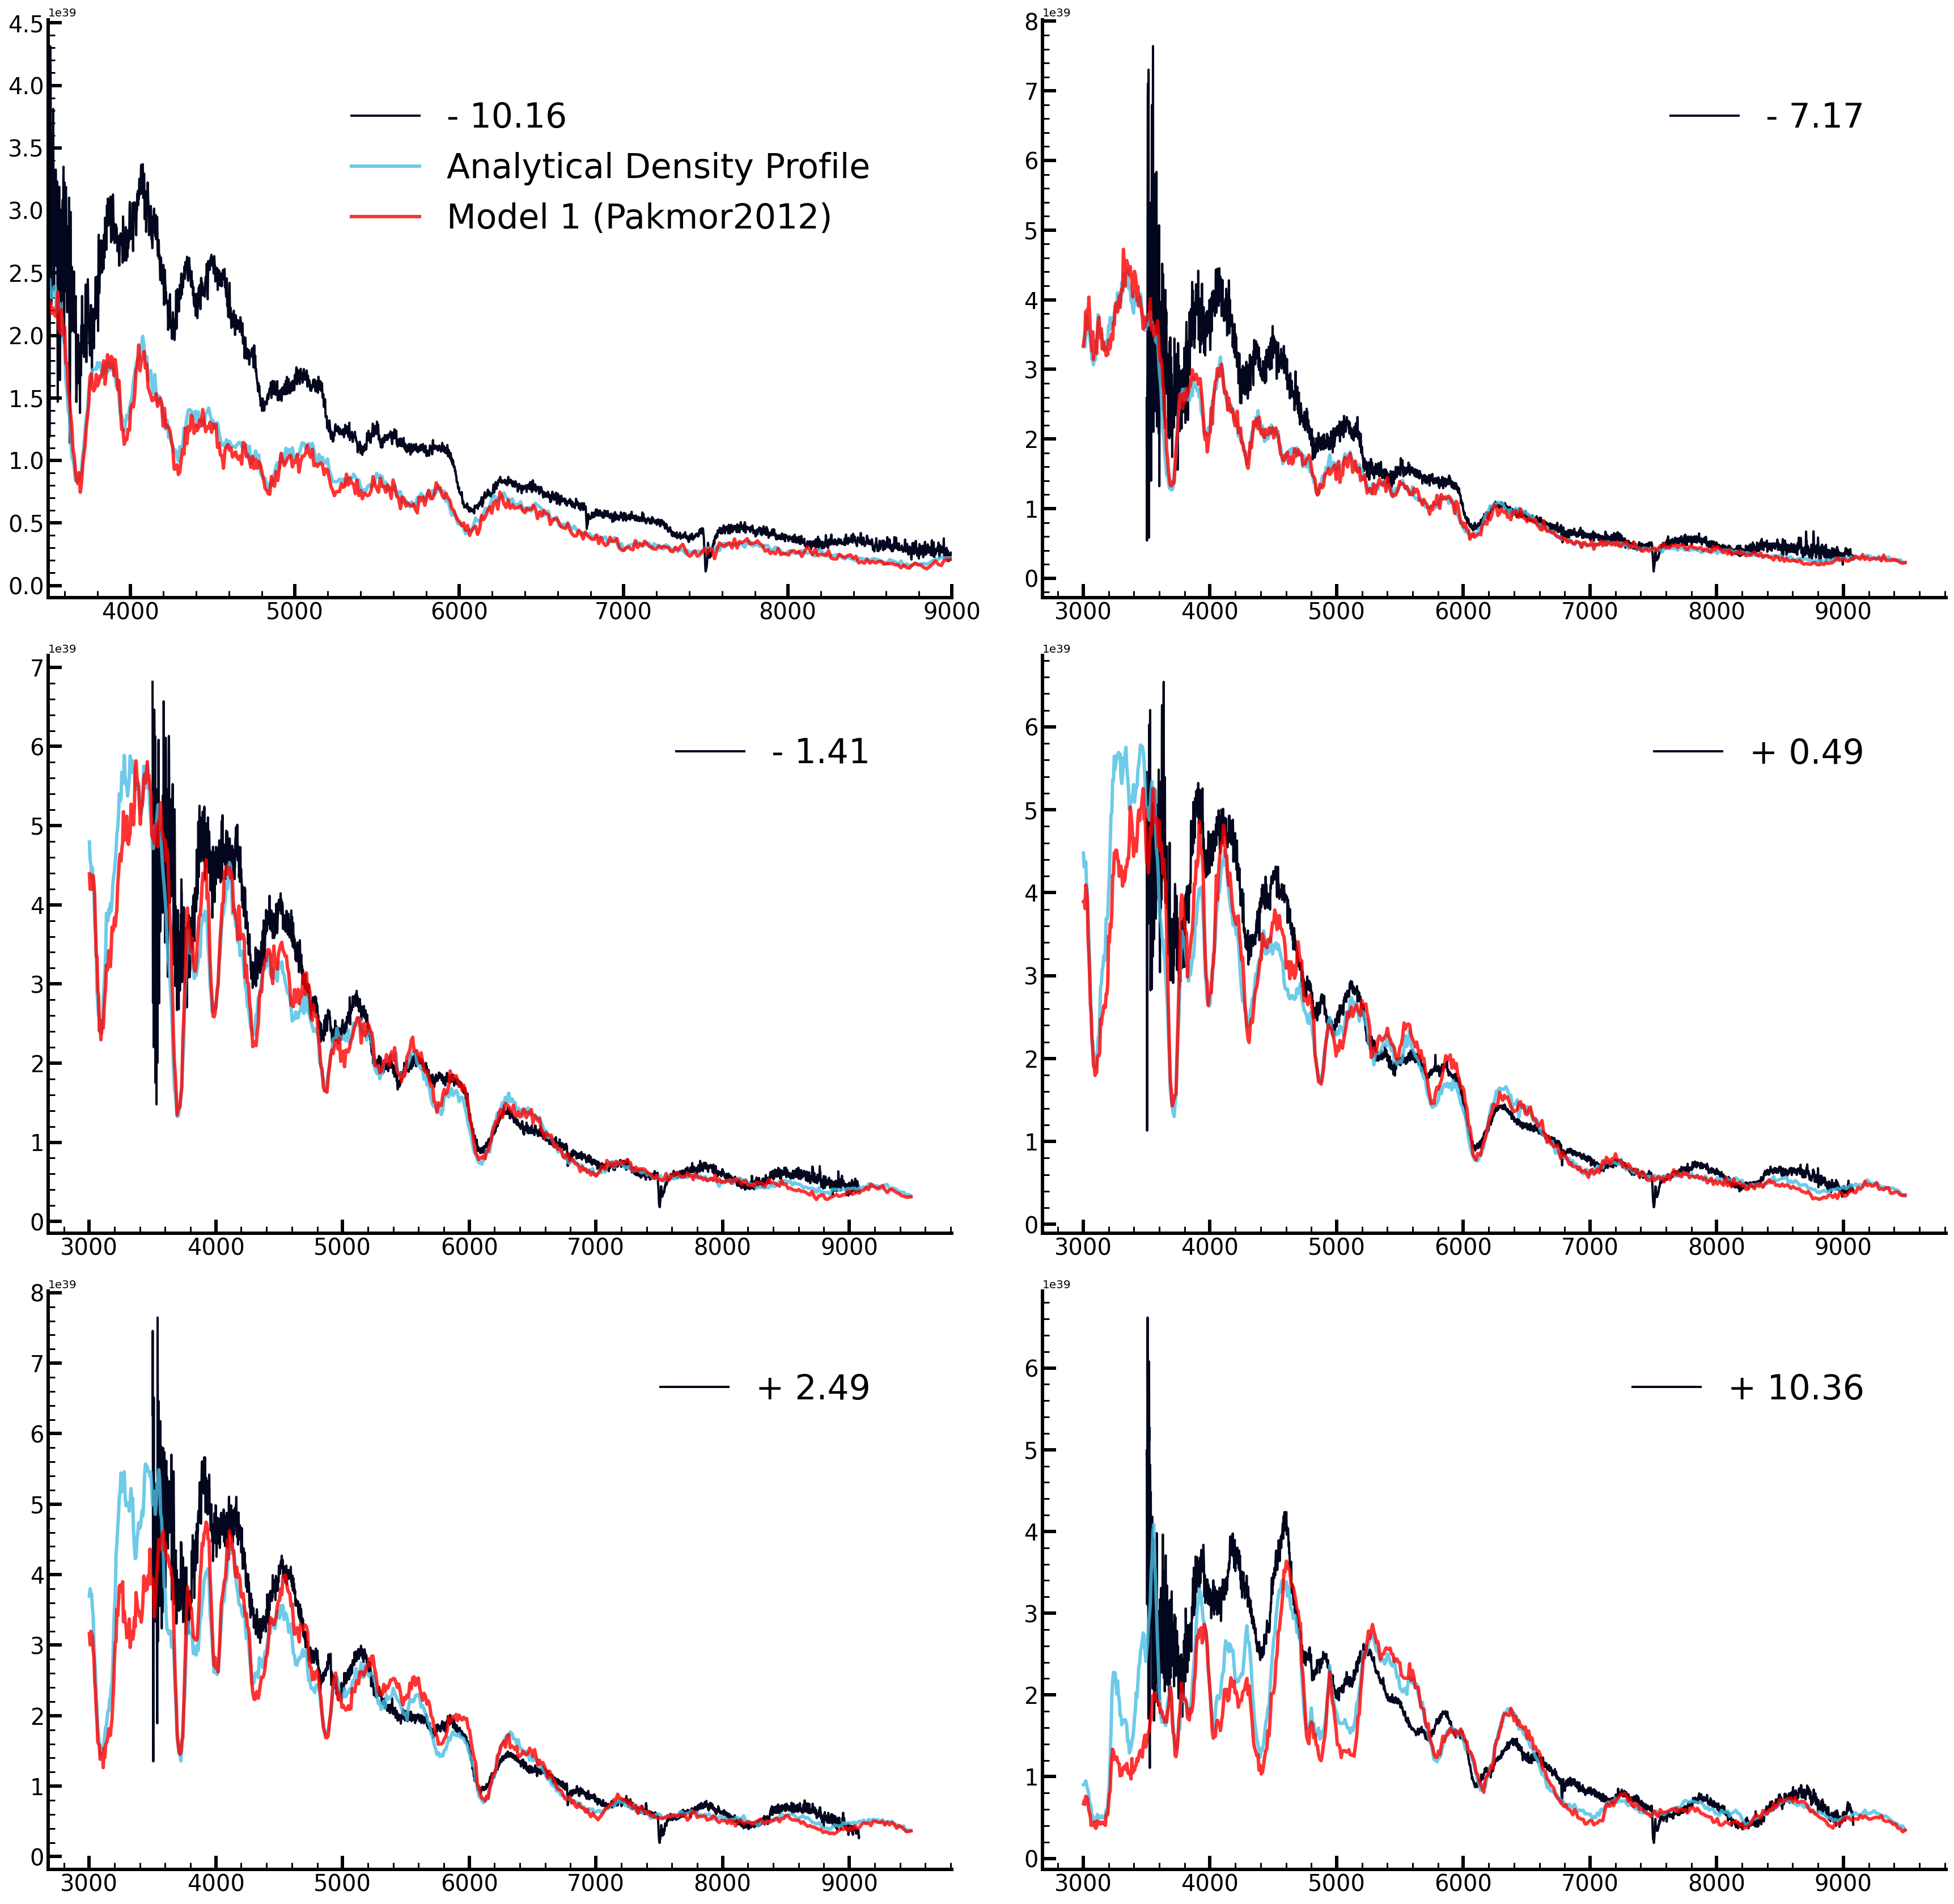

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(30, 30))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

#fig.delaxes(axs[4, 2])
#fig.delaxes(axs[4, 1])

plot_spectrum(list_text_spectra[0], axs[0, 0], 1000, 200, 0.5e39, 0.1e39, phase='- 10.16')
plot_sedona_spectrum(list_sedona_spectra[3], axs[0, 0], label='Analytical Density Profile', color='#48bfe3')
plot_sedona_spectrum(list_sedona_spectra_old[1], axs[0, 0], label='Model 1 (Pakmor2012)', color='red')



axs[0, 0].set_xlim(3500, 9000)

# +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ #

'''
dict_label = {r'$\rm -\ Ca\,II\ $':[3650, 2.8e39],
             r'$\rm -\ Si\,II\ $':[3900, 3.1e39],
             r'$\rm -\ Co\,II\ $':[4060, 3.2e39],
             r'$\rm -\ Fe\,III\ $':[4200, 2.7e39],
             r'$\rm ---\ Si\,III\ $':[4340, 2.7e39],
             r'$\rm \ S\,II\ $':[4470, 2.7e39],
             r'$\rm ----\ Fe\,II\ ,\ S\,II\ $':[4580, 2.3e39],
             r'$\rm -\ Fe\,II\ $':[4670, 2.0e39],
             r'$\rm \ Fe\,III\ $':[4765, 1.8e39],
             r'$\rm ---\ Fe\,III\ $':[4880, 1.5e39],
             r'$\rm -\ S\,II\ $':[5020, 1.7e39], 
             r'$\rm \ --S\,II\ $':[5240, 1.3e39],
             r'$\rm ---\ S\,II\ $':[5360, 1.3e39],
             r'$\rm -\ Si\,III\ $':[5490, 1.2e39],
             r'$\rm -\ Si\,II\ 5972\ $':[5800, 1.1e39],
             r'$\rm -\ Si\,II\ 6355\ $':[6000, 1.0e39],
             r'$\rm -\ C\,II\ 6580$':[6330, 1.0e39],
             r'$\rm -\ C\,II\ $':[6940, 0.7e39],
             r'$\rm -\ O\,I\ $':[7390, 0.6e39],
             r'$\rm -\ Ca\, II\ $':[8200, 0.6e39]}

for (line, [wavelength, width]) in dict_label.items():
    axs[0, 0].text(wavelength, width, line, fontsize = 25, rotation = 'vertical', color='#660708')   
            
axs[0, 0].text(3600, 4.1e39, '[A]', fontsize=30, fontweight='bold', color='black')        

# +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ #
'''
plot_spectrum(list_text_spectra[1], axs[0, 1], 1000, 200, 1e39, 0.2e39, phase='- 7.17')
plot_sedona_spectrum(list_sedona_spectra[6], axs[0, 1], label = '__nolabel__', color='#48bfe3')
plot_sedona_spectrum(list_sedona_spectra_old[3], axs[0, 1], label = '__nolabel__', color='red')

plot_spectrum(list_text_spectra[2], axs[1, 0], 1000, 200, 1.0e39, 0.2e39, phase='- 1.41')
plot_sedona_spectrum(list_sedona_spectra[12], axs[1, 0], label = '__nolabel__', color='#48bfe3')
plot_sedona_spectrum(list_sedona_spectra_old[5], axs[1, 0], label = '__nolabel__', color='red')

plot_spectrum(list_text_spectra[3], axs[1, 1], 1000, 200, 1e39, 0.2e39, phase='+ 0.49')
plot_sedona_spectrum(list_sedona_spectra[14], axs[1, 1],  label = '__nolabel__', color='#48bfe3')
plot_sedona_spectrum(list_sedona_spectra_old[7], axs[1, 1], label = '__nolabel__', color='red')

plot_spectrum(list_text_spectra[4], axs[2, 0], 1000, 200, 1e39, 0.2e39, phase='+ 2.49')
plot_sedona_spectrum(list_sedona_spectra[16], axs[2, 0],  label = '__nolabel__', color='#48bfe3')
plot_sedona_spectrum(list_sedona_spectra_old[9], axs[2, 0], label = '__nolabel__', color='red')

plot_spectrum(list_text_spectra[5], axs[2, 1], 1000, 200, 1e39, 0.2e39, phase='+ 10.36')
plot_sedona_spectrum(list_sedona_spectra[24], axs[2, 1],  label = '__nolabel__', color='#48bfe3')
plot_sedona_spectrum(list_sedona_spectra_old[-1], axs[2, 1], label = '__nolabel__', color='red')

#plot_sedona_spectrum(list_sedona_spectra_old[-1], axs[2, 1], label = '__nolabel__', color='red')



# fig.text(.5, 0.1, r'$\rm Rest\ Wavelength\ [\AA]$', 
#          ha='center', va='center', rotation='horizontal', fontsize=40);

# fig.text(0.09, .5, r'$\rm Luminosity\ [erg~s^{-1}~\AA^{-1}]$', 
#          ha='center', va='center', rotation='vertical', fontsize=40);



In [24]:
# Plot density profile :

violent_merger_dat  = '/Users/anirbandutta/Documents/SNEXP/TypeIa_Models/vm_abundances.dat'
violent_merger_df = pd.read_csv(violent_merger_dat, sep=',', engine='python')

In [26]:
density_vm = violent_merger_df['Density']
velocity_vm = violent_merger_df['Velocity']

In [28]:
density_homo = homologous_expansion(density_vm, 0.001157, 1)

In [29]:
model6 = '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/Model6/sedona_model_6.mod'

In [38]:
columns = ['radius', 'velocity', 'density', 'temp', 'c12', 'o16', 'ne20', 'mg24', 'si28', 's32', 'ca40', 'fe54',
                                          'ni56', 'ni58']
model6_df = pd.read_csv(model6, sep='\s+', skiprows=3, names=columns, engine='python')

In [39]:
model6_df

,radius,velocity,density,temp,c12,o16,ne20,mg24,si28,s32,ca40,fe54,ni56,ni58
0,3.722200e+12,4.308100e+07,1.073416e-08,19569.0,0.01,0.54,0.09,0.18,0.12,0.02,0.0,0.0,0.00,0.00
1,7.444400e+12,8.616200e+07,9.260038e-09,19138.0,0.01,0.53,0.10,0.18,0.12,0.02,0.0,0.0,0.00,0.00
2,1.116700e+13,1.292400e+08,7.911521e-09,18708.0,0.01,0.53,0.11,0.17,0.11,0.02,0.0,0.0,0.00,0.00
3,1.488900e+13,1.723200e+08,6.743103e-09,18277.0,0.02,0.52,0.12,0.17,0.11,0.02,0.0,0.0,0.00,0.00
4,1.861100e+13,2.154100e+08,5.741506e-09,17846.0,0.02,0.44,0.11,0.14,0.10,0.02,0.0,0.0,0.13,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2.345000e+14,2.714100e+09,4.965379e-13,1357.5,0.47,0.50,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
63,2.382200e+14,2.757200e+09,4.226192e-13,1315.4,0.47,0.50,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
64,2.419400e+14,2.800300e+09,3.596578e-13,1275.3,0.47,0.50,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
65,2.456700e+14,2.843300e+09,3.060356e-13,1236.9,0.47,0.50,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00


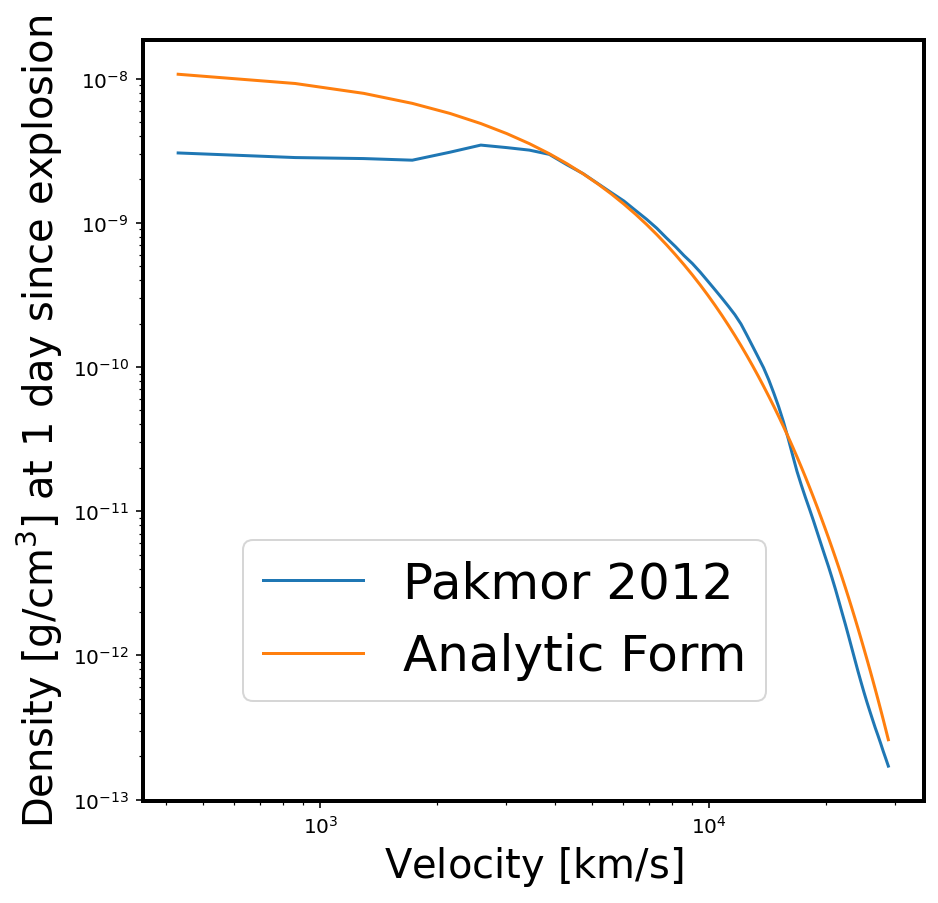

In [56]:
fig_app = plt.figure(figsize = (7, 7))
ax = fig_app.add_subplot(111)
plt.rcParams['axes.linewidth'] = 2

ax.plot(velocity_vm, density_homo, label='Pakmor 2012')
ax.plot(model6_df['velocity'] / 10**5, model6_df['density'], label='Analytic Form')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\rm Velocity\ [km/s]$', fontsize=20)
ax.set_ylabel(r'$\rm Density\ [g/cm^{3}]\ at\ 1\ day\ since\ explosion$', fontsize=20)

plt.legend(fontsize=25, borderaxespad=2)

#plot_params(ax, ml_x = 5000, mil_x = 1000, ml_y = 0.1, mil_y = 0.01, s=10, invert=False)